# General Two-Layer Neural Network Classifer from scratch with ReLU Activation Function and Cross-Entropy Loss function On MNIST Dataset
- ## Part 1: Implementation of Two-Layer Neural Network Classifier on MNIST Datset from Ground Up
  1. ### Data Loading
  2. ### Preprocessing
  3. ### Compose TwoLayerNeuralNetworkModule Class
  4. ### Training
  5. ### Results and Visualization
- ## Part 2: Building a Neural Network Classifier with Sklearn Package

<div style="text-align: center;">
  <img src='data/two_layer_neural_network.png' width='40%'>
</div>


## Part 1: Implementation of Two-Layer Neural Network Classifier on MNIST Datset from Ground Up

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip, pickle

In [5]:
# Download MNIST dataset independently
# Load MNIST dataset

with gzip.open(filename='data/mnist.pkl.gz', mode='rb') as dataset:
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = pickle.load(file=dataset, encoding='latin1')

# Check shapes of each data:
print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


### Preprocessing: Normalize Pixels

In [7]:
# Since all digits are between [0, 1] there is no need for scale normalization
mu = X_train.mean(axis=0)

X_train -= mu
X_valid -= mu
X_test  -= mu

### Two Layer Neural Network Module

In [9]:
# Main part
class TwoLayerNeuralNetworkModule:

    def __init__(self, num_features=784, num_hiddens=20, num_classes=10):
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes

        # Initilize weights randomly, set all biases to zero
        self.params = {}
        
        self.params['W1'] = np.random.randn(num_features, num_hiddens) * 1e-3    # X -> (m, n), W1 -> (n, h)
        self.params['b1'] = np.zeros(num_hiddens)
        
        self.params['W2'] = np.random.randn(num_hiddens, num_classes) * 1e-3     # W1 -> (n, h), X -> (h, c)
        self.params['b2'] = np.zeros(num_classes)

    def accuracy(self, y_pred, y_true):
        return np.mean(y_pred == y_true) * 100

    def predict(self, X:):
        scores = self.forward(X)
        return np.argmax(scores, axis=1)  # returns maximum value in each row as a predicted class

    def predict_probs(self, X):
        scores = self.forward(X)
        return self.softmax(scores)

    def softmax(self, scores):
        scores = scores - np.max(scores, axis=1, keepdims=True)   # subtract max value in each row from, for numerical stability in softmax
        exp_scores = np.exp(scores)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    
    
    def cross_entropy_loss_gradients(self, scores, y_true, mode='train'):
        """if mode == 'train' -> returns loss, dscores.
           if mode == 'test'  -> return loss.
        """
        m = y_true.shape[0]
        probabilities = self.softmax(scores)
        loss = (-1 / m) * np.sum(np.log(probabilities[range(m), y_true]))

        if mode == 'test': return loss

        # Compute backward gradients
        dscores = np.copy(probabilities)
        dscores[range(m), y_true] -= 1   # exactly like the backward formula
        dscores /= m 

        return (loss, dscores)

    def forward(self, X):
        W1, b1 = self.params['W1'], self.params['b1']
        self.W2, b2 = self.params['W2'], self.params['b2']   # only self.W2 is needed for back-propagation step in backward()
        
        # Inference step
        self.h_in = X @ W1 + b1             # hidden layer input || h_in.shape = (m, h)
        self.h_out = np.maximum(0, self.h_in)    # RELU activation function || h_out.shape = (m, h)

        scores = self.h_out @ self.W2 + b2       # compute logits (raw class scores)

        return scores

    def backward(self, X, dscores):
        # compute the gradients, done by chain rule
        self.gradients = {}

        self.gradients['db2'] = dscores.sum(axis=0)  # dscores.shape = (m, c) -> sum axis=0 (sum each column) -> db2.shape = (c, )
        self.gradients['dW2'] = self.h_out.T @ dscores  # h_out.T.shape = (h, m) || dscores.shape = (m, c) => dW2.shape = (h, c) -> same as W2.shape

        dh = dscores @ self.W2.T    # dscores.shape = (m, c) || W2.shape = (h, c) => dh.shape = (m, h)
        dh[self.h_in < 0] = 0       # gradient of RELU node

        self.gradients['db1'] = dh.sum(axis=0)  # dh.shape = (m, h) -> sum axis=0 (sum each column) -> db1.shape = (h, ) 
        self.gradients['dW1'] = X.T @ dh  # X.T.shape = (n, m) || dh.shape = (m, h) => dW1.shape = (n, h) -> same as W1.shape

        return self.gradients

    
    def one_train_step(self, X, y):
        # forward pass
        scores = self.forward(X)

        # compute loss and scores gradients
        loss, dscores = self.cross_entropy_loss_gradients(scores, y, 'train')

        # backward pass (back-propagation)
        self.gradients = self.backward(X, dscores)

        return (loss, self.gradients)

    def fit(self, X_train, y_train, X_valid, y_valid, batch_size=64, alpha=.001, lmbda=1e-4, num_epochs=10):
        
        big_tik = time.time()  # capture training start time
        
        m, n = X_train.shape
        num_batches = m // batch_size

        losses = []
        for epoch in range(num_epochs):
            # Capture start time
            epoch_tik = time.time()
            
            epoch_train_loss = 0
            
            for _ in range(num_batches):
                # Select a random mini-batch of size batch_size
                idxs = np.random.choice(m, batch_size, replace=False)   # enough epochs would more likely cover all the samples frequently
                X_batch, y_batch = X_train[idxs], y_train[idxs]

                W1, b1 = self.params['W1'], self.params['b1']
                W2, b2 = self.params['W2'], self.params['b2']

                # Train for one step
                data_loss, self.gradients = self.one_train_step(X_batch, y_batch)
                reg_loss = (1 / 2) * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
                total_batch_loss = data_loss + (lmbda * reg_loss)
                epoch_train_loss += total_batch_loss
                
                losses.append(total_batch_loss)

                # Regularization just for weights
                self.gradients['dW1'] += lmbda * W1
                self.gradients['dW2'] += lmbda * W2

                # Parameters update step
                for param in self.params:
                    self.params[param] -= alpha * self.gradients['d' + param]   # 'd' indicates

            # report statistics after each epoch
            epoch_train_loss /= num_batches     # calculate average train loss per batch
            total_valid_loss = self.cross_entropy_loss_gradients(self.forward(X_valid), y_valid, mode='test')
            
            epoch_tok = time.time()
            epoch_tik_tok = 1000 * (epoch_tok - epoch_tik)   # convert time to mili seconds
            
            print(f"Epoch {epoch+1:2} || training loss: {epoch_train_loss:5.4f} || validation loss: {total_valid_loss:5.4f} || time: {epoch_tik_tok:.1f} ms")

            if (epoch+1) % 5 == 0:
                train_accuracy = self.accuracy(self.predict(X_train), y_train)
                valid_accuracy = self.accuracy(self.predict(X_valid), y_valid)
                print(f"--------- train accuracy: {train_accuracy:5.3f}% || validation accuracy: {valid_accuracy:5.3f}% --------\n")    
            
        big_tok = time.time()  # capture training end time
        print(f"Total Training Time: {big_tok - big_tik:.2f} seconds")
        
        return losses

### Training

In [11]:
# Training
MLP_model = TwoLayerNeuralNetworkModule(num_hiddens=30)
losses = MLP_model.fit(X_train, y_train, X_valid, y_valid, alpha=0.05, lmbda=.001, num_epochs=35, batch_size=64)

Epoch  1 || training loss: 1.5043 || validation loss: 0.5039 || time: 1482.5 ms
Epoch  2 || training loss: 0.4146 || validation loss: 0.2980 || time: 1504.8 ms
Epoch  3 || training loss: 0.3248 || validation loss: 0.2596 || time: 1901.1 ms
Epoch  4 || training loss: 0.2893 || validation loss: 0.2379 || time: 1771.5 ms
Epoch  5 || training loss: 0.2749 || validation loss: 0.2192 || time: 1674.7 ms
--------- train accuracy: 93.350% || validation accuracy: 93.830% --------

Epoch  6 || training loss: 0.2584 || validation loss: 0.2065 || time: 1438.9 ms
Epoch  7 || training loss: 0.2490 || validation loss: 0.1936 || time: 1796.0 ms
Epoch  8 || training loss: 0.2369 || validation loss: 0.1867 || time: 1571.8 ms
Epoch  9 || training loss: 0.2328 || validation loss: 0.1804 || time: 1559.2 ms
Epoch 10 || training loss: 0.2291 || validation loss: 0.1736 || time: 1092.3 ms
--------- train accuracy: 95.164% || validation accuracy: 95.230% --------

Epoch 11 || training loss: 0.2180 || validation 

In [12]:
# Accuracy on Test set
y_test_pred = MLP_model.predict(X_test)
test_acc = MLP_model.accuracy(y_test_pred, y_test)
print(f"Accuracy on Test Set: {test_acc:.3f}%")

Accuracy on Test Set: 96.460%


### Plot Training Loss over Epoch

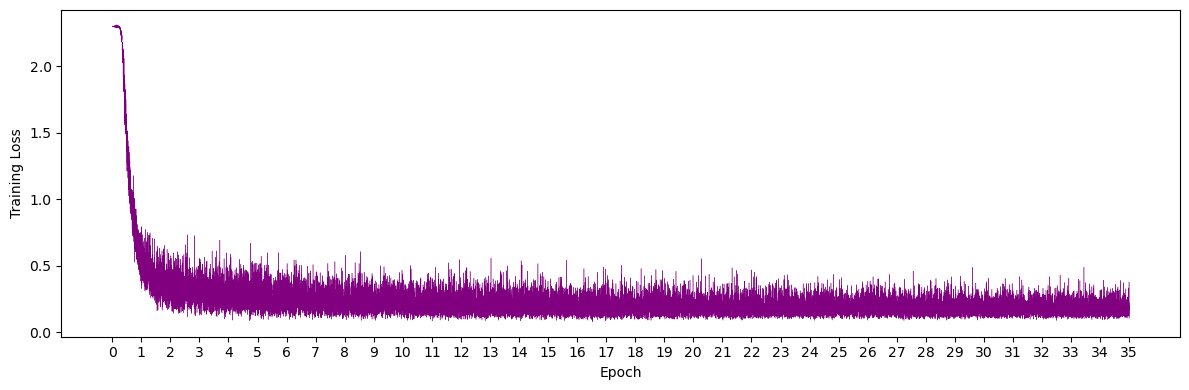

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(losses, color='purple', lw=0.3)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(range(0, len(losses) + 1, (50000 // 64)) ,range(0, 36)) # 50000 = num_train_samples || 64 = num_batches || 35 = num_epochs
plt.tight_layout()
plt.show()

### Visualize 10 Random Predicted Results

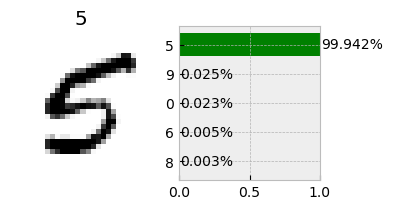

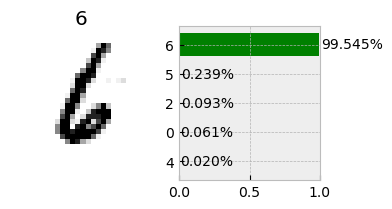

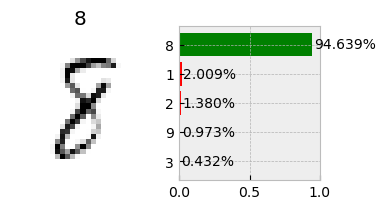

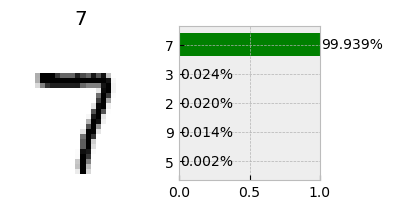

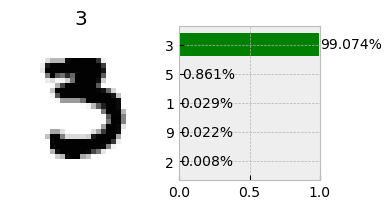

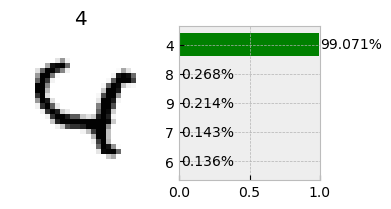

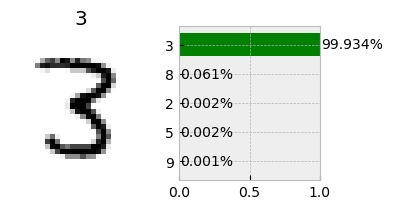

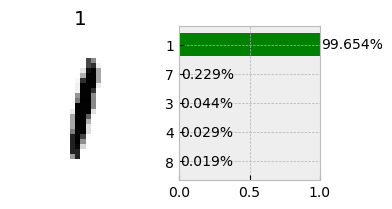

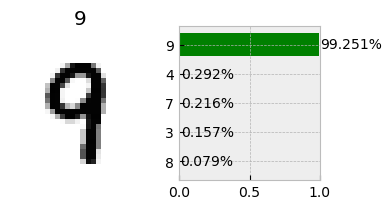

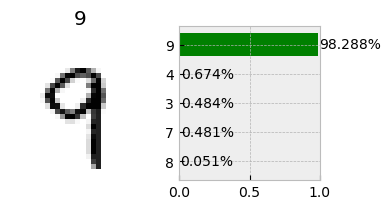

In [16]:
# Plot 10 digits and their predicted probabilities

plt.style.use('bmh')

num_samples = 10
for _ in range(num_samples):
    plt.figure(figsize=(4, 2))
    idx = np.random.choice(X_test.shape[0])
    probabilities = MLP_model.predict_probs(X_test[idx].reshape(1, -1))[0]  # [0] selects the first row, shape = (10, )

    # Plot the selected test digit
    plt.subplot(121)
    plt.imshow((X_test[idx] + mu).reshape(28, 28), cmap='Greys')
    plt.axis('off')
    plt.title(f'{np.argmax(probabilities)}')

    
    # Plot top 5 predictions probabilities of the digit
    colors_list = ['green' if y_test[idx] == i else 'red' for i in np.argsort(probabilities)[5:]]
    tick_labels = np.argsort(probabilities)[5:]
    
    plt.subplot(122)
    barh = plt.barh(range(5), np.sort(probabilities)[5:], color=colors_list, tick_label=tick_labels)
    
    # Add probabilities of predictions as a text
    for i, bb in enumerate(barh):
        plt.text(bb.get_width() + 0.01, bb.get_y() + (bb.get_height() / 2), 
                 f'{np.sort(probabilities)[5:][i] * 100:.3f}%', 
                 va='center') 
    plt.xlim(0, 1)

### Visualize 10 Misclassified Data

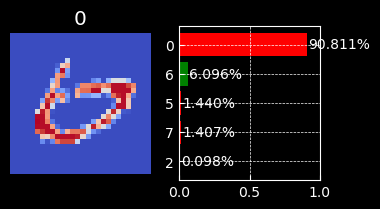

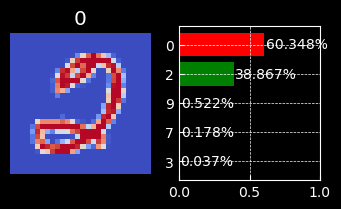

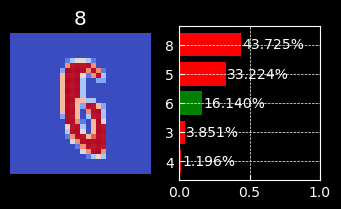

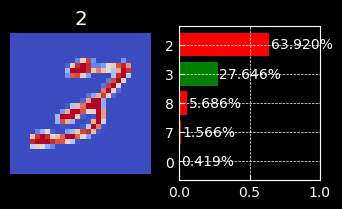

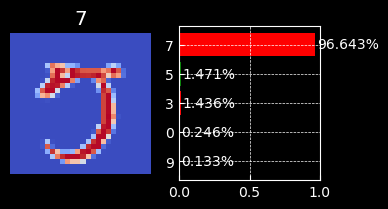

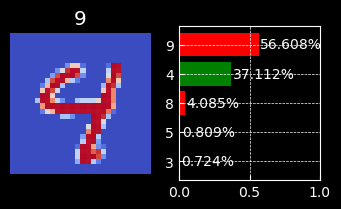

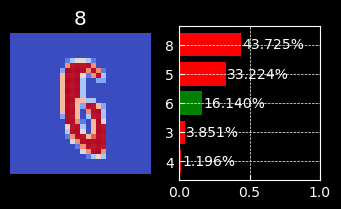

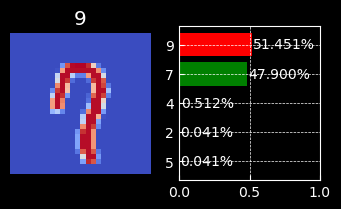

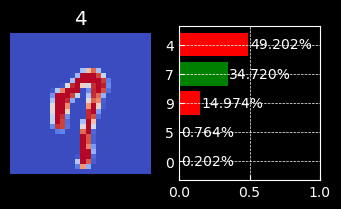

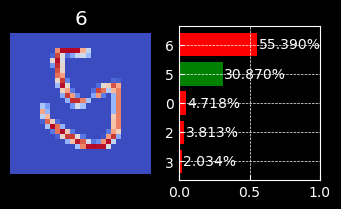

In [18]:
# Plot 10 misclassified digits and their predicted probabilities
plt.style.use('dark_background')

num_samples = 10
y_pred = MLP_model.predict(X_test)
wrong_preds_idxs = np.flatnonzero(y_test != y_pred)  # computes all misclassified samples indices

for _ in range(num_samples):
    plt.figure(figsize=(4, 2))
    wrong_idx = np.random.choice(wrong_preds_idxs)
    probabilities = MLP_model.predict_probs(X_test[wrong_idx].reshape(1, -1))[0]  # [0] selects the first row, shape = (10, )

    # Plot the selected test digit
    plt.subplot(121)
    plt.imshow((X_test[wrong_idx] + mu).reshape(28, 28), cmap='coolwarm')
    plt.axis('off')
    plt.title(f'{np.argmax(probabilities)}')

    
    # Plot top 5 predictions probabilities of the digit
    colors_list = ['green' if y_test[wrong_idx] == i else 'red' for i in np.argsort(probabilities)[5:]]
    tick_labels = np.argsort(probabilities)[5:]
    
    plt.subplot(122)
    barh = plt.barh(range(5), np.sort(probabilities)[5:], color=colors_list, tick_label=tick_labels)
    
    # Add probabilities of predictions as a text
    for i, bb in enumerate(barh):
        plt.text(bb.get_width() + 0.01, bb.get_y() + (bb.get_height() / 2), 
                 f'{np.sort(probabilities)[5:][i] * 100:.3f}%', 
                 va='center') 
    plt.xlim(0, 1)

## Part 2: Neural Networks with ScikitLearn

In [20]:
from sklearn.neural_network import MLPClassifier

In [21]:
model = MLPClassifier(hidden_layer_sizes=(35,), learning_rate='adaptive', alpha=1, max_iter=50, verbose=1)
model.fit(X_train, y_train)

Iteration 1, loss = 0.83680457
Iteration 2, loss = 0.47426967
Iteration 3, loss = 0.43028581
Iteration 4, loss = 0.41111776
Iteration 5, loss = 0.40009594
Iteration 6, loss = 0.39377333
Iteration 7, loss = 0.38958720
Iteration 8, loss = 0.38602087
Iteration 9, loss = 0.38301127
Iteration 10, loss = 0.38047290
Iteration 11, loss = 0.37870950
Iteration 12, loss = 0.37688734
Iteration 13, loss = 0.37596089
Iteration 14, loss = 0.37515064
Iteration 15, loss = 0.37414985
Iteration 16, loss = 0.37333298
Iteration 17, loss = 0.37293454
Iteration 18, loss = 0.37206096
Iteration 19, loss = 0.37165277
Iteration 20, loss = 0.37126769
Iteration 21, loss = 0.37073436
Iteration 22, loss = 0.36986238
Iteration 23, loss = 0.36997567
Iteration 24, loss = 0.36938102
Iteration 25, loss = 0.36893051
Iteration 26, loss = 0.36898100
Iteration 27, loss = 0.36872039
Iteration 28, loss = 0.36817094
Iteration 29, loss = 0.36804565
Iteration 30, loss = 0.36767454
Iteration 31, loss = 0.36740909
Iteration 32, los

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=1, hidden_layer_sizes=(35,), learning_rate='adaptive',
              max_iter=50, verbose=1)

In [22]:
train_acc = model.score(X_train, y_train)
print(f"Training Accuracy = {train_acc:.4f}%")

test_acc = model.score(X_test, y_test)
print(f"Test Accuracy  = {test_acc:.4f}%")

Training Accuracy = 0.9572%
Test Accuracy  = 0.9565%
